In [377]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

0. Set Hyperparamters

In [385]:
train_ratio = 0.8
validation_ratio = 0.2
epochs = 200
batch_size = 512

1. Import Data

In [386]:
# 1. Import data
NY_data = pd.read_csv("data/NY_data.csv")

# 2. Split data into x and y values
y = NY_data['price']
X = NY_data.drop(columns=['price'])

# 4. Split data into Train vs. Test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

In [387]:
DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, input_dim=X.shape[1], activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

DNN.compile(loss='mse', optimizer='adam')

2. Model Initilization

In [388]:
history = DNN.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 1s 5ms/step - loss: 4137063022592.0000 - val_loss: 3730411094016.0000
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 4136684748800.0000 - val_loss: 3730378063872.0000
Epoch 3/200
64/64 [==============================] - 0s 4ms/step - loss: 4135644561408.0000 - val_loss: 3730262720512.0000
Epoch 4/200
64/64 [==============================] - 0s 4ms/step - loss: 4133697355776.0000 - val_loss: 3729736335360.0000
Epoch 5/200
64/64 [==============================] - 0s 4ms/step - loss: 4130422652928.0000 - val_loss: 3728566386688.0000
Epoch 6/200
64/64 [==============================] - 0s 4ms/step - loss: 4125768810496.0000 - val_loss: 3726283374592.0000
Epoch 7/200
64/64 [==============================] - 0s 4ms/step - loss: 4118609657856.0000 - val_loss: 3720677687296.0000
Epoch 8/200
64/64 [==============================] - 0s 4ms/step - loss: 4109511426048.0000 - val_loss: 3717330632704.0000
Epoch 9/200
64/6

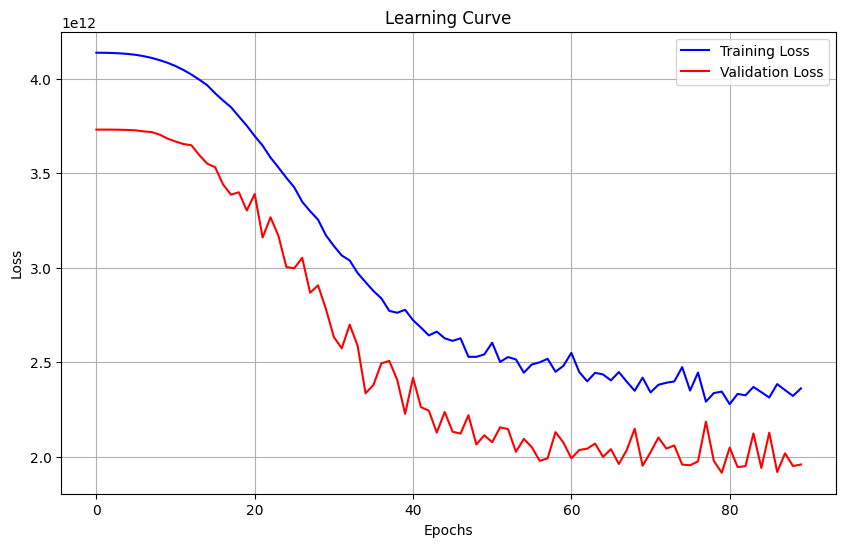

In [389]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [390]:
loss = DNN.evaluate(X_test, y_test)
print("Test Loss:", loss)

318/318 [==============================] - 0s 574us/step - loss: 1593081724928.0000
Test Loss: 1593081724928.0


In [391]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = DNN.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

318/318 [==============================] - 0s 539us/step
Mean Absolute Error: 360769.6281029501
Mean Squared Error: 1593082096049.8352
Root Mean Squared Error: 1262173.5601928267
R-squared: 0.48153989540314013


In [60]:
predictions = DNN.predict([[3.0,1.0,60.0,12022.0,1176.0], [3.0,2.0,2.02,12521.0,1600.0], [4.0,4.0,37.0,12062.0,4000.0]]);
print("Expected Prices: 175000.0, 425000, 1300000")
print("Predicted Prices: {}, {}, {}".format(predictions[0][0], predictions[1][0], predictions[2][0]))

1/1 [==============================] - 0s 68ms/step
Expected Prices: 175000.0, 425000, 1300000
Predicted Prices: 417723.625, 384912.0, 1796492.125
